# Quickstart guide

In this notebook we will through all the steps from downloading the data and training a model to evaluating the results. Check out the `environment.yml` file for the required Python packages.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/neuralcora

/content/drive/.shortcut-targets-by-id/1Bdsu_-uiFfPX07yPDt46rXnTcKqhlwSw/neuralcora


In [ ]:
# git config --global user.email "yl1127.pan@gmail.com"
# git config --global user.name "Yunlong"

In [ ]:
# !pip install plotly
# conda install -c conda-forge matplotlib
# conda install -c conda-forge xarray dask netCDF4 bottleneck
# pip install torch
# conda install seaborn
# conda install scipy
# conda install -c conda-forge ipywidgets
# !pip install nbformat

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [ ]:
from src import (
    open_period,
    ensure_lat_lon_dims,
    subset_by_years,
    load_land_mask,
    CoraDataset,
    NeuralCoraCNN,
    fit,
    create_predictions,
    rename_for_score,
    compute_weighted_rmse,
)

from src.networks import (
    build_resnet,
    build_uresnet,
    # build_unet,
    # build_unet_google,
    PeriodicConv2d,
    ConvBlock,
    _validate_sequence
)


## Downloading the data

The data is hosted here. For this guide we will simply download the a year (1997) data.

In [ ]:
# To do

## Open the data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import os

data_dir = "/content/drive/MyDrive/regridded_zeta_step2"
DATA_DIR = data_dir
# List all files in the directory
datasets = [f for f in os.listdir(data_dir) if f.endswith(".nc")]
datasets.sort()  # sort for readability

print("Available datasets:")
for ds in datasets:
    print(ds)

Available datasets:
NY_1979_180_360.nc
NY_1980_180_360.nc
NY_1981_180_360.nc
NY_1982_180_360.nc
NY_1983_180_360.nc
NY_1984_180_360.nc
NY_1985_180_360.nc
NY_1986_180_360.nc
NY_1987_180_360.nc
NY_1988_180_360.nc
NY_1989_180_360.nc
NY_1990_180_360.nc
NY_1991_180_360.nc
NY_1992_180_360.nc
NY_1993_180_360.nc
NY_1994_180_360.nc
NY_1995_180_360.nc
NY_1996_180_360.nc
NY_1997_180_360.nc
NY_1998_180_360.nc
NY_1999_180_360.nc
NY_2000_180_360.nc
NY_2001_180_360.nc
NY_2002_180_360.nc
NY_2003_180_360.nc
NY_2004_180_360.nc
NY_2005_180_360.nc
NY_2006_180_360.nc
NY_2007_180_360.nc
NY_2008_180_360.nc
NY_2009_180_360.nc
NY_2010_180_360.nc
NY_2011_180_360.nc
NY_2012_180_360.nc
NY_2013_180_360.nc
NY_2014_180_360.nc
NY_2015_180_360.nc
NY_2016_180_360.nc
NY_2017_180_360.nc
NY_2018_180_360.nc
NY_2019_180_360.nc
NY_2020_180_360.nc
NY_2021_180_360.nc
NY_2022_180_360.nc
real_land_mask_180_360.nc


In [ ]:
mask = xr.open_dataset(f"{data_dir}/real_land_mask_180_360.nc")

In [ ]:
# --- Examples ---

# (A) Full-year span (matches what you asked):
# Note: your data starts at 1998; 1997 will be skipped automatically.
TIME_PERIOD = "2018-2022"

ds = open_period(TIME_PERIOD, data_dir=DATA_DIR, engine='h5netcdf')

# (B) Date span:
# ds = open_period("19970101-20101231", data_dir=DATA_DIR)

# (C) Hourly precision:
# ds = open_period("1998010100-1998123123", data_dir=DATA_DIR)

# (D) With dask chunking (if dask installed) for better performance:
# ds = open_period("1998-2022", data_dir=DATA_DIR, chunks={'time': 24*30}, parallel=True)


In [ ]:
print(ds)

<xarray.Dataset> Size: 23GB
Dimensions:    (time: 43824, latitude: 180, longitude: 360)
Coordinates:
  * time       (time) datetime64[ns] 351kB 2018-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25
Data variables:
    zeta       (time, latitude, longitude) float64 23GB dask.array<chunksize=(274, 6, 23), meta=np.ndarray>


In [ ]:
# Select: zeta
zeta = (ds["zeta"].sel(time=slice("2015-01-01T00:00:00", "2022-12-31T23:00:00")))

# Quick sanity checks
print(zeta)

<xarray.DataArray 'zeta' (time: 43824, latitude: 180, longitude: 360)> Size: 23GB
dask.array<concatenate, shape=(43824, 180, 360), dtype=float64, chunksize=(275, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 351kB 2018-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25


In [ ]:
zeta_val = (ds["zeta"].sel(time=slice("2022-01-01T00:00:00", "2022-12-31T23:00:00")))
zeta_val

<xarray.DataArray 'zeta' (time: 8760, latitude: 180, longitude: 360)> Size: 5GB
dask.array<getitem, shape=(8760, 180, 360), dtype=float64, chunksize=(274, 6, 23), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 70kB 2022-01-01 ... 2022-12-31T23:00:00
  * latitude   (latitude) float64 1kB 40.25 40.26 40.26 ... 41.49 41.49 41.5
  * longitude  (longitude) float64 3kB -74.5 -74.49 -74.48 ... -71.26 -71.25

In [ ]:
str(zeta.time[0].values)[:19]
# '1998-01-01T00:00:00'

'2018-01-01T00:00:00'

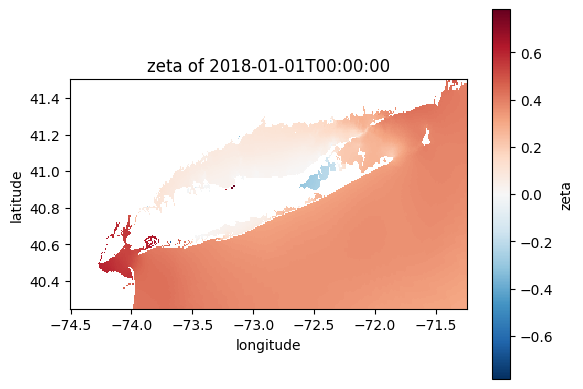

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
qm = zeta.isel(time=0).plot(ax=ax)
ax.set_aspect(1.5)
ax.set_title(f"zeta of {str(zeta.time[0].values)[:19]}")
plt.show()

## Train a neural network

Now let's train a simple convolutional neural network.

In [ ]:
import os
from pathlib import Path
from collections import OrderedDict
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.__version__

# Set reproducibility seeds
torch.manual_seed(42)
np.random.seed(42)

# Priority order: CUDA > TPU > MPS > CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
elif hasattr(torch, 'xla') or 'xla' in torch.__dict__:
    try:
        import torch_xla.core.xla_model as xm
        device = xm.xla_device()
    except ImportError:
        device = torch.device("cpu")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)


Using device: cuda


### PyTorch dataset


In [ ]:
# Configuration aligned with the quickstart dataset
DATA_DIR = Path(data_dir)
TARGET_VAR = "zeta"
max_lead = 1
TIME_STRIDE = max_lead
INPUT_STEPS = 12

# Optional mask; set MASK_PATH to None to skip
MASK_PATH: Optional[Path] = DATA_DIR / "real_land_mask_180_360.nc"
MASK_VARIABLE = "mask"  # variable name inside the mask file
MASK_THRESHOLD = 0.5  # when MASK_VALID_EQUALS is None, keep values >= threshold
MASK_VALID_EQUALS: Optional[float] = 0.0  # e.g. set to 0.0 if 0 marks valid land
MASK_EQUAL_TOL = 1e-6
MASK_INVERT = False  # flip valid/invalid if your mask marks land with low values

if not DATA_DIR.exists():
    raise FileNotFoundError(f"DATA_DIR {DATA_DIR} does not exist. Adjust the path before continuing.")


In [ ]:
# Open the requested period, keep only the target variable, and optionally thin the time dimension.
ds_raw = open_period(TIME_PERIOD, data_dir=DATA_DIR, engine='h5netcdf')
ds_raw = ensure_lat_lon_dims(ds_raw)

if TARGET_VAR not in ds_raw:
    raise KeyError(f"{TARGET_VAR!r} not found in dataset variables: {list(ds_raw.data_vars)}")

ds_raw = ds_raw[[TARGET_VAR]]

land_mask = load_land_mask(MASK_PATH, variable=MASK_VARIABLE)
if land_mask is not None:
    land_mask = land_mask.interp_like(ds_raw[TARGET_VAR], method="nearest")
    if MASK_VALID_EQUALS is not None:
        valid = np.isclose(land_mask, MASK_VALID_EQUALS, atol=MASK_EQUAL_TOL)
    else:
        valid = land_mask >= MASK_THRESHOLD
    if MASK_INVERT:
        valid = ~valid
    ds_raw[TARGET_VAR] = ds_raw[TARGET_VAR].where(valid)

if TIME_STRIDE and TIME_STRIDE > 1:
    ds_raw = ds_raw.isel(time=slice(0, None, TIME_STRIDE))

# ds_raw

In [ ]:
# Derive simple train/validation/test splits from the available years.
available_years = np.unique(ds_raw.time.dt.year.values)
if available_years.size < 3:
    raise ValueError(
        "TIME_PERIOD must span at least three distinct years to create train/valid/test splits."
    )

train_years = available_years[:-2]
valid_years = available_years[-2:-1]
test_years = available_years[-1:]

if train_years.size == 0:
    raise ValueError("Extend TIME_PERIOD so that at least one year is available for training.")

# select data subsets

ds_train = subset_by_years(ds_raw, train_years)
ds_valid = subset_by_years(ds_raw, valid_years)
ds_test = subset_by_years(ds_raw, test_years)

print(f"Train years: {train_years.tolist()}")
print(f"Valid years: {valid_years.tolist()}")
print(f"Test years:  {test_years.tolist()}")
# print(ds_train[TARGET_VAR])
# print(ds_valid[TARGET_VAR])
# print(ds_test[TARGET_VAR])


Train years: [2018, 2019, 2020]
Valid years: [2021]
Test years:  [2022]


In [ ]:
print(f"Train samples: {ds_train.sizes['time']}")
print(f"Valid samples: {ds_valid.sizes['time']}")
print(f"Test samples: {ds_test.sizes['time']}")


Train samples: 26304
Valid samples: 8760
Test samples: 8760


In [ ]:
var_dict = OrderedDict({TARGET_VAR: None})
batch_size = 64
lead_time = max_lead  # number of index steps ahead (4 * TIME_STRIDE hours)
input_steps = INPUT_STEPS

In [ ]:
#  Flattens multiple variables (and optional pressure levels) into a single channels axis.
#  Normalizes with train stats.
#  Produces pairs of (x[t], y[t+lead]) in channels-first tensors for PyTorch.
#  Exposes init_time, valid_time, etc.

train_ds = CoraDataset(
    ds_train,
    var_dict,
    lead_time,
    input_steps=input_steps,
    load_into_memory=True,
)
valid_ds = CoraDataset(
    ds_valid,
    var_dict,
    lead_time,
    input_steps=input_steps,
    mean=train_ds.mean,
    std=train_ds.std,
    load_into_memory=True,
)
test_ds = CoraDataset(
    ds_test,
    var_dict,
    lead_time,
    input_steps=input_steps,
    mean=train_ds.mean,
    std=train_ds.std,
    load_into_memory=True,
)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


In [ ]:
print(f'Train samples: {len(train_ds)} | Input channels: {train_ds.input_channels} | Output channels: {train_ds.output_channels}')
print(f'Input steps: {train_ds.input_steps} | Target lead time: {train_ds.lead_time}')

Train samples: 26292 | Input channels: 12 | Output channels: 1
Input steps: 12 | Target lead time: 1


### Create and train model

Use the PyTorch builders in `src.networks` by selecting a model kind in the next cell.
The defaults mirror the original CNN and add ResNet/UNet-style options.


In [ ]:
from __future__ import annotations

from typing import Callable, Iterable, List, Sequence

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

In [ ]:
class DLWPUNet(nn.Module):
    """
    DLWP-like U-Net (smart padding):
      • AvgPool down / nearest up
      • Periodic padding in longitude (W), reflect in latitude (H)
      • Pads to multiple of 2^(n_layers-1) and trims the padded rim after the head
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        n_layers: int = 4,
        filters_start: int = 4,
        kernel: int = 3,
        activation: str = "relu",  # ignored; kept for API parity
        dropout: float = 0.0,
        periodic: bool = True,     # use PeriodicConv2d if available
    ):
        super().__init__()
        assert n_layers >= 2
        self.flatten_sequences = True
        self.n_layers = n_layers

        act = nn.ReLU(inplace=True)
        k = kernel

        # choose conv op
        ConvOp = PeriodicConv2d if periodic else None
        def make_conv(ic, oc, ks, bias=True):
            if ConvOp is not None:
                return ConvOp(ic, oc, ks, bias=bias)
            pad = ks // 2
            return nn.Conv2d(ic, oc, ks, padding=pad, bias=bias)

        chs = [filters_start * (2 ** i) for i in range(n_layers)]  # e.g. [4,8,16,32]

        # encoder
        self.enc_blocks = nn.ModuleList()
        self.pools = nn.ModuleList()
        c_in = in_channels
        for li, c_out in enumerate(chs):
            self.enc_blocks.append(nn.Sequential(
                make_conv(c_in, c_out, k), nn.BatchNorm2d(c_out), act,
                make_conv(c_out, c_out, k), nn.BatchNorm2d(c_out), act,
                nn.Dropout2d(dropout) if dropout > 0 else nn.Identity(),
            ))
            if li < n_layers - 1:
                self.pools.append(nn.AvgPool2d(2, ceil_mode=False))
            c_in = c_out

        # decoder
        self.ups = nn.ModuleList()
        self.dec_blocks = nn.ModuleList()
        rev = list(reversed(chs))  # [32,16,8,4]
        for i in range(n_layers - 1):
            up_in, skip_ch = rev[i], rev[i + 1]
            self.ups.append(nn.Upsample(scale_factor=2, mode="nearest"))
            self.dec_blocks.append(nn.Sequential(
                make_conv(up_in + skip_ch, skip_ch, k), nn.BatchNorm2d(skip_ch), act,
                make_conv(skip_ch,       skip_ch, k),   nn.BatchNorm2d(skip_ch), act,
                nn.Dropout2d(dropout) if dropout > 0 else nn.Identity(),
            ))

        self.head = make_conv(chs[0], out_channels, 1)

    def forward(self, x):
        # Flatten (N,T,C,H,W) -> (N*T,C,H,W) if needed
        if getattr(self, "flatten_sequences", False):
            if x.dim() == 5:
                x = x.flatten(0, 1)
            elif x.dim() != 4:
                raise ValueError(f"Expected 4D or 5D input, got {x.dim()}D")

        # --- SMART PADDING (no zeros) ---
        # Make H,W multiples of 2^(L-1) (L=4 -> 8). Pad RIGHT (lon) circularly, BOTTOM (lat) reflect.
        m = 2 ** (self.n_layers - 1)
        H, W = x.shape[-2:]
        ph = (-H) % m          # rows to add at bottom
        pw = (-W) % m          # cols to add at right

        if pw:
            # pad (left=0, right=pw, top=0, bottom=0) in circular (longitude wrap)
            x = torch.nn.functional.pad(x, (0, pw, 0, 0), mode='circular')
        if ph:
            # pad (left=0, right=0, top=0, bottom=ph) in reflect (latitude)
            x = torch.nn.functional.pad(x, (0, 0, 0, ph), mode='reflect')

        # encoder
        skips, y = [], x
        for i, block in enumerate(self.enc_blocks):
            y = block(y)
            if i < len(self.pools):
                skips.append(y)
                y = self.pools[i](y)

        # decoder
        for up, dec in zip(self.ups, self.dec_blocks):
            y = up(y)
            skip = skips.pop()
            # shapes should already match with even factors; keep a safety clip
            if skip.shape[-2:] != y.shape[-2:]:
                h, w = skip.shape[-2:]
                Ht, Wt = y.shape[-2:]
                dh = max(0, (h - Ht) // 2)
                dw = max(0, (w - Wt) // 2)
                skip = skip[..., dh:dh+Ht, dw:dw+Wt]
            y = torch.cat([skip, y], dim=1)
            y = dec(y)

        out = self.head(y)

        # --- Trim the smart padding rim back to original H,W (not "cropping" data; just removing padding) ---
        if ph or pw:
            out = out[..., :H, :W]
        return out


def build_unet_dlwp(
    input_shape,               # (H, W, C_in)
    channels_out: int,
    n_layers: int = 3,
    filters_start: int = 4,
    kernel: int = 3,
    activation: str = "relu",  # kept for signature compatibility; ignored
    dropout: float = 0.0,
    periodic: bool = True,
):
    """
    Factory wrapper to match existing build_* signatures.
    """
    in_channels = input_shape[-1]
    return DLWPUNet(
        in_channels=in_channels,
        out_channels=channels_out,
        n_layers=n_layers,
        filters_start=filters_start,
        kernel=kernel,
        activation=activation,  # unused, kept for compatibility
        dropout=dropout,
        periodic=periodic,
    )

# Expose symbols like other models
try:
    __all__ += ["DLWPUNet", "build_unet_dlwp"]
except NameError:
    __all__ = ["DLWPUNet", "build_unet_dlwp"]

In [ ]:
class CappedLeakyReLU(nn.Module):
    def __init__(self, negative_slope=0.1, cap=10.0):
        super().__init__()
        self.neg = negative_slope
        self.cap = cap
    def forward(self, x):
        x = torch.where(x >= 0, x, self.neg * x)
        if self.cap is not None:
            x = torch.clamp(x, max=self.cap)
        return x

def _dlwp_block(in_ch, out_ch, cap=10.0, periodic=True):
    act = CappedLeakyReLU(0.1, cap)
    if periodic:
        conv1 = PeriodicConv2d(in_ch, out_cht, 3)
        conv2 = PeriodicConv2d(cout, cout, 3)
    else:
        conv1 = nn.Conv2d(in_ch, out_cht, 3, padding=1)
        conv2 = nn.Conv2d(cout, cout, 3, padding=1)
    return nn.Sequential(conv1, act, conv2, act)

class UNet2D_DLWP(nn.Module):
    """
    2-level UNet (like your snippet):
      enc1 -> pool -> enc2 -> pool -> bottleneck -> up2 -> dec2 -> up1 -> dec1 -> head
    """
    def __init__(self, in_ch, out_ch, base=32, cap=10.0, periodic=True):
        super().__init__()
        # encoder
        self.enc1 = _dlwp_block(in_ch,   base,     cap, periodic)
        self.pool1= nn.MaxPool2d(2)                 # 180x360 -> 90x180
        self.enc2 = _dlwp_block(base,   base*2,    cap, periodic)
        self.pool2= nn.MaxPool2d(2)                 # 90x180  -> 45x90
        # bottleneck
        self.bott = _dlwp_block(base*2, base*4,    cap, periodic)
        # decoder
        self.up2  = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)  # 45x90  -> 90x180
        self.dec2 = _dlwp_block(base*4, base*2,    cap, periodic)
        self.up1  = nn.ConvTranspose2d(base*2, base,   2, stride=2)  # 90x180 -> 180x360
        self.dec1 = _dlwp_block(base*2, base,      cap, periodic)
        # head
        Conv = PeriodicConv2d if periodic else nn.Conv2d
        self.out  = Conv(base, out_ch, 1)

    def forward(self, x):
        # Accept (N,(in_ch, out_ch) or (N, T, C, H, W) -> flatten time into batch if present
        if x.dim() == 5:
            x = x.flatten(0, 1)  # (N*T, C, H, W)
        elif x.dim() != 4:
            raise ValueError(f"Expected 4D or 5D input, got {x.dim()}D")

        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        b  = self.bott(p2)
        u2 = self.up2(b)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))
        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))
        return self.out(d1)

def build_unet2d_dlwp(
    input_shape,
    channels_out: int,
    base: int = 32,
    cap: float = 10.0,
    periodic: bool = True,
):
    in_ch = int(input_shape[-1])
    out_ch = int(channels_out)
    return UNet2D_DLWP(in_ch=in_ch, out_ch=out_ch, base=base, cap=cap, periodic=periodic)

# expose
try:
    __all__ += ["UNet2D_DLWP", "build_unet2d_dlwp"]
except NameError:
    __all__ = ["UNet2D_DLWP", "build_unet2d_dlwp"]

In [ ]:
class ConvBlock(nn.Module):
    """Conv block with configurable BatchNorm placement."""

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        *,
        bn_position: str | None = None,
        use_bias: bool = True,
        dropout: float = 0.0,
        activation: str = "relu",
    ) -> None:
        super().__init__()
        bn_position = bn_position.lower() if bn_position is not None else None
        if bn_position not in {None, "pre", "mid", "post"}:
            raise ValueError("bn_position must be one of None, 'pre', 'mid', or 'post'.")

        self.bn_position = bn_position
        self.bn_pre = nn.BatchNorm2d(in_channels) if bn_position == "pre" else None
        self.conv = PeriodicConv2d(in_channels, out_channels, kernel_size, bias=use_bias)
        self.bn_mid = nn.BatchNorm2d(out_channels) if bn_position == "mid" else None
        self.bn_post = nn.BatchNorm2d(out_channels) if bn_position == "post" else None
        self.activation = _activation_layer(activation)()
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.bn_pre is not None:
            x = self.bn_pre(x)
        x = self.conv(x)
        if self.bn_mid is not None:
            x = self.bn_mid(x)
        x = self.activation(x)
        if self.bn_post is not None:
            x = self.bn_post(x)
        x = self.dropout(x)
        return x

def _activation_layer(name: str) -> Callable[[], nn.Module]:
    name = name.lower()
    if name == "relu":
        return nn.ReLU
    if name == "gelu":
        return nn.GELU
    if name in {"silu", "swish"}:
        return nn.SiLU
    if name in {"leakyrelu", "leaky_relu", "leaky"}:
        return lambda: nn.LeakyReLU(0.1)
    if name == "elu":
        return nn.ELU
    if name == "linear":
        return nn.Identity
    raise ValueError(f"Unsupported activation '{name}'.")

In [ ]:
class UNet(nn.Module):
    """UNet with residual blocks and periodic convolutions (smart padding)."""

    def __init__(
        self,
        input_channels: int,
        n_layers: int,
        filters_start: int,
        channels_out: int,
        *,
        kernel: int = 3,
        u_skip: bool = True,
        res_skip: bool = True,
        bn_position: str | None = None,
        dropout: float = 0.0,
        activation: str = "relu",
    ) -> None:
        super().__init__()
        if n_layers < 1:
            raise ValueError("n_layers must be >= 1.")

        self.n_layers = n_layers
        self.flatten_sequences = True
        self.u_skip = u_skip
        self.res_skip = res_skip
        self.relu = nn.ReLU()

        filters_per_layer = [filters_start * (2**i) for i in range(n_layers)]

        # -------- down path --------
        self.down = nn.ModuleList()
        in_channels = input_channels
        for i, filters in enumerate(filters_per_layer):
            block = nn.ModuleDict({
                "residual": PeriodicConv2d(in_channels, filters, 1, bias=False),
                "block1": ConvBlock(
                    in_channels, filters, kernel,
                    bn_position=bn_position, dropout=dropout, activation=activation,
                ),
                "block2": ConvBlock(
                    filters, filters, kernel,
                    bn_position=bn_position, dropout=dropout, activation="linear",
                ),
                "pool": nn.MaxPool2d(2) if i != n_layers - 1 else nn.Identity(),
            })
            self.down.append(block)
            in_channels = filters

        # -------- up path --------
        self.up = nn.ModuleList()
        current_filters = filters_per_layer[-1]
        for filters in reversed(filters_per_layer[:-1]):
            concat_channels = (2 * filters) if u_skip else filters  # <- correct concat width
            stage = nn.ModuleDict({
                "upsample": nn.Upsample(scale_factor=2, mode="nearest"),
                "conv": PeriodicConv2d(current_filters, filters, kernel),
                "residual": PeriodicConv2d(concat_channels, filters, 1, bias=False),
                "block1": ConvBlock(
                    concat_channels, filters, kernel,
                    bn_position=bn_position, dropout=dropout, activation=activation,
                ),
                "block2": ConvBlock(
                    filters, filters, kernel,
                    bn_position=bn_position, dropout=dropout, activation="linear",
                ),
            })
            self.up.append(stage)
            current_filters = filters

        self.head = PeriodicConv2d(filters_per_layer[0], channels_out, 1)

    def forward(self, x):
        # flatten time if present
        if self.flatten_sequences and x.dim() == 5:
            x = x.flatten(0, 1)
        elif x.dim() not in (4, 5):
            raise ValueError(f"Expected 4D or 5D input, got {x.dim()}D")

        # SMART PAD: periodic in lon (W), reflect in lat (H)
        orig_H, orig_W = x.shape[-2:]
        m = 2 ** (self.n_layers - 1)
        ph = (-orig_H) % m
        pw = (-orig_W) % m
        if pw:
            x = F.pad(x, (0, pw, 0, 0), mode="circular")  # right pad in W
        if ph:
            x = F.pad(x, (0, 0, 0, ph), mode="reflect")   # bottom pad in H

        # encoder
        skips = []
        y = x
        for i, block in enumerate(self.down):
            res = block["residual"](y) if self.res_skip else None
            y = block["block1"](y)
            y = block["block2"](y)
            if self.res_skip:
                y = y + res
            if not isinstance(block["pool"], nn.Identity):
                skips.append(y)            # save pre-pooled feature for skip
                y = block["pool"](y)

        # decoder
        for stage in self.up:
            y = stage["upsample"](y)
            y = stage["conv"](y)
            if self.u_skip:
                skip = skips.pop()
                # safety crop if off-by-one
                if skip.shape[-2:] != y.shape[-2:]:
                    Hs, Ws = skip.shape[-2:]
                    Ht, Wt = y.shape[-2:]
                    dh = max(0, (Hs - Ht) // 2); dw = max(0, (Ws - Wt) // 2)
                    skip = skip[..., dh:dh+Ht, dw:dw+Wt]
                y = torch.cat([skip, y], dim=1)

            res = stage["residual"](y) if self.res_skip else None
            y = stage["block1"](y)
            y = stage["block2"](y)
            if self.res_skip:
                y = y + res

        out = self.head(y)

        # trim padded rim back to original size
        if ph or pw:
            out = out[..., :orig_H, :orig_W]
        return out

def build_unet(
    input_shape: Sequence[int],
    n_layers: int,
    filters_start: int,
    channels_out: int,
    *,
    kernel: int = 3,
    u_skip: bool = True,
    res_skip: bool = True,
    bn_position: str | None = None,
    dropout: float = 0.0,
    activation: str = "relu",
) -> UNet:
    channels = input_shape[-1]
    return UNet(
        channels,
        n_layers,
        filters_start,
        channels_out,
        kernel=kernel,
        u_skip=u_skip,
        res_skip=res_skip,
        bn_position=bn_position,
        dropout=dropout,
        activation=activation,
      )

In [ ]:
from typing import Sequence
import torch.nn.functional as F


class _GoogleBasicBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout: float) -> None:
        super().__init__()
        self.conv1 = PeriodicConv2d(in_channels, out_channels, 3)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.act1  = nn.LeakyReLU()
        self.conv2 = PeriodicConv2d(out_channels, out_channels, 3)
        self.drop  = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        self.short = PeriodicConv2d(in_channels, out_channels, 3)  # same res

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = self.short(x)
        y = self.conv1(x)
        y = self.bn1(y)
        y = self.act1(y)
        y = self.conv2(y)
        y = self.drop(y)
        return y + residual


class _GoogleDownsampleBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, dropout: float) -> None:
        super().__init__()
        self.bn1  = nn.BatchNorm2d(in_channels)
        self.act1 = nn.LeakyReLU()
        self.pool = nn.MaxPool2d(2)
        self.bn2  = nn.BatchNorm2d(in_channels)
        self.act2 = nn.LeakyReLU()
        self.conv = PeriodicConv2d(in_channels, out_channels, 3)   # after pool
        self.drop = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        self.short= PeriodicConv2d(in_channels, out_channels, 3, stride=2)  # downsample skip

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = self.short(x)          # stride-2
        y = self.bn1(x)
        y = self.act1(y)
        y = self.pool(y)                  # H/2 × W/2
        y = self.bn2(y)
        y = self.act2(y)
        y = self.conv(y)
        y = self.drop(y)
        return y + residual


class _GoogleUpsampleBlock(nn.Module):
    def __init__(self, in_channels: int, skip_channels: int, out_channels: int, dropout: float) -> None:
        super().__init__()
        total_channels = in_channels + skip_channels
        self.ups   = nn.Upsample(scale_factor=2, mode="nearest")
        self.bn1   = nn.BatchNorm2d(total_channels)
        self.act1  = nn.LeakyReLU()
        self.conv1 = PeriodicConv2d(total_channels, out_channels, 3)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.act2  = nn.LeakyReLU()
        self.conv2 = PeriodicConv2d(out_channels, out_channels, 3)
        self.drop  = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        self.short = PeriodicConv2d(total_channels, out_channels, 3)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        x = self.ups(x)  # upsample first
        # safety: center-crop skip if off-by-one
        if skip.shape[-2:] != x.shape[-2:]:
            Ht, Wt = x.shape[-2:]
            Hs, Ws = skip.shape[-2:]
            dh = max(0, (Hs - Ht) // 2); dw = max(0, (Ws - Wt) // 2)
            skip = skip[..., dh:dh+Ht, dw:dw+Wt]
        y = torch.cat([x, skip], dim=1)
        residual = self.short(y)
        y = self.bn1(y); y = self.act1(y)
        y = self.conv1(y)
        y = self.bn2(y); y = self.act2(y)
        y = self.conv2(y)
        y = self.drop(y)
        return y + residual


# ---------- UNetGoogle with smart padding ----------
class UNetGoogle(nn.Module):
    """UNet variant inspired by Agrawal et al. with smart padding (periodic lon, reflect lat)."""

    def __init__(
        self,
        input_channels: int,
        filters: Sequence[int],
        output_channels: int,
        *,
        dropout: float = 0.0,
    ) -> None:
        super().__init__()
        filters = _validate_sequence("filters", filters)
        if len(filters) < 2:
            raise ValueError("filters must contain at least two entries.")

        self.flatten_sequences = True
        self.num_pools = len(filters) - 1  # #downs/ups

        # initial (top) block
        self.initial = _GoogleBasicBlock(input_channels, filters[0], dropout)

        # encoder (downsample blocks)
        self.encoder = nn.ModuleList()
        cur = filters[0]
        for f in filters[:-1]:
            self.encoder.append(_GoogleDownsampleBlock(cur, f, dropout))
            cur = f

        # bottleneck
        self.bottleneck = _GoogleBasicBlock(cur, filters[-1], dropout)
        cur = filters[-1]

        # decoder (upsample blocks)
        enc_out_chs = list(filters[:-1])             # [f0, f1, ..., f_{L-2}]
        dec_skip_chs = list(reversed(enc_out_chs[:-1])) + [enc_out_chs[0]]
        self.decoder = nn.ModuleList()
        for f in reversed(filters[:-1]):
            self.decoder.append(_GoogleUpsampleBlock(cur, f, f, dropout))
            cur = f

        # head
        self.output_conv = PeriodicConv2d(cur, output_channels, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # flatten + smart pad (keep your existing code)
        if self.flatten_sequences and x.dim() == 5:
            x = x.flatten(0, 1)
        elif x.dim() not in (4, 5):
            raise ValueError(f"Expected 4D or 5D input, got {x.dim()}D")

        orig_H, orig_W = x.shape[-2:]
        m = 2 ** self.num_pools
        ph = (-orig_H) % m
        pw = (-orig_W) % m
        if pw: x = F.pad(x, (0, pw, 0, 0), mode="circular")
        if ph: x = F.pad(x, (0, 0, 0, ph), mode="reflect")

        # initial + encoder: save skips AFTER each down block, plus the top one
        y = self.initial(x)         # full-res features (channels = filters[0])
        skips = [y]                 # top-level skip
        for enc in self.encoder:    # each down block returns lower-res features
            y = enc(y)
            skips.append(y)

        # bottleneck
        y = self.bottleneck(y)

        # decoder: drop the deepest (it matches bottleneck res; not used as a skip)
        skips.pop()                 # remove deepest entry
        for dec in self.decoder:
            skip = skips.pop()      # pop matching higher-res skip
            y = dec(y, skip)

        out = self.output_conv(y)

        # trim padded rim
        if ph or pw:
            out = out[..., :orig_H, :orig_W]
        return out


def build_unet_google(
    filters: Sequence[int],
    input_shape: Sequence[int],
    output_channels: int,
    *,
    dropout: float = 0.0,
) -> UNetGoogle:
    channels = input_shape[-1]
    return UNetGoogle(
        channels,
        filters,
        output_channels,
        dropout=dropout,
    )

In [ ]:
model_kind = "unet"  # choose from: 'cnn', 'resnet',

# 'uresnet', 'unet', 'unet_google', 'unet_dlwp', 'unet2d_dlwp'

spatial_shape = train_ds.inputs.shape[-2:]
input_shape = (*spatial_shape, train_ds.input_channels)

def make_cnn():
    return NeuralCoraCNN(
        train_ds.input_channels,
        hidden_channels=[8, 32, 32, 8],
        kernel_size=5,
        out_channels=train_ds.output_channels,
        dropout=0.0,
    )

def make_resnet():
    return build_resnet(
        filters=[8, 32, 32, 8, train_ds.output_channels],
        kernels=[3, 3, 3, 3, 3],
        input_shape=input_shape,
        bn_position="post",
        dropout=0.1,
        activation="relu",
    )

def make_uresnet():
    return build_uresnet(
        filters=[8, 32, 8, train_ds.output_channels],
        kernels=[5, 5, 5, 5],
        unres=[2, 2],
        input_shape=input_shape,
        bn_position="mid",
        dropout=0.1,
        activation="relu",
    )

def make_unet():
    return build_unet(
        input_shape=input_shape,
        n_layers=4,
        filters_start=4,
        channels_out=train_ds.output_channels,
        kernel=3,
        dropout=0.1,
        activation="relu",
    )

def make_unet_google():
    return build_unet_google(
        filters=[8, 16, 16, 8],
        input_shape=input_shape,
        output_channels=train_ds.output_channels,
        dropout=0.1,
    )

def make_unet_dlwp():
    return build_unet_dlwp(
        input_shape=input_shape,
        channels_out=train_ds.output_channels,
        n_layers=5,       # factor 4; 180×360 is fine
        filters_start=8,
        kernel=5,
        activation="relu",  # ignored in our ReLU-only version; kept for API parity
        dropout=0.1,
        periodic=True,    # set True if PeriodicConv2d exists in your repo
    )
def make_unet2d_dlwp():
    return build_unet2d_dlwp(
        input_shape=input_shape,                   # (*H, *W, C_in) from your current ds
        channels_out=train_ds.output_channels,     # Cout (e.g., 1*C)
        base=16,
        cap=10.0,
        periodic=True,                             # False if PeriodicConv2d isn't available
    )

model_factory = {
    "cnn": make_cnn,
    "resnet": make_resnet,
    "uresnet": make_uresnet,
    "unet": make_unet,
    "unet_google": make_unet_google,
    "unet_dlwp": make_unet_dlwp,      # ← add
    "unet2d_dlwp": make_unet2d_dlwp
}

model = model_factory[model_kind]().to(device)

# model_factory = {
#     "cnn": make_cnn,
#     "resnet": make_resnet,
#     "uresnet": make_uresnet,
#     "unet": make_unet,
#     "unet_google": make_unet_google,
# }

# if model_kind not in model_factory:
#     raise ValueError(f"Unknown model_kind {model_kind!r}")

# model = model_factory[model_kind]().to(device)

In [ ]:
model

UNet(
  (relu): ReLU()
  (down): ModuleList(
    (0): ModuleDict(
      (residual): PeriodicConv2d(
        (pad): PeriodicPad2d()
        (conv): Conv2d(12, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (block1): ConvBlock(
        (conv): PeriodicConv2d(
          (pad): PeriodicPad2d()
          (conv): Conv2d(12, 4, kernel_size=(3, 3), stride=(1, 1))
        )
        (activation): ReLU()
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
      (block2): ConvBlock(
        (conv): PeriodicConv2d(
          (pad): PeriodicPad2d()
          (conv): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1))
        )
        (activation): Identity()
        (dropout): Dropout2d(p=0.1, inplace=False)
      )
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ModuleDict(
      (residual): PeriodicConv2d(
        (pad): PeriodicPad2d()
        (conv): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
  

In [ ]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Model '{model_kind}' parameter count: {num_params:,}")


Model 'unet' parameter count: 35,441


In [ ]:
# Re-run this cell after creating the model to reset optimizer/scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-5,
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
)


In [ ]:
num_epochs = 8
history = fit(
    model,
    train_loader,
    optimizer=optimizer,
    criterion=criterion,
    epochs=num_epochs,
    device=device,
    valid_loader=valid_loader,
    scheduler=scheduler,
)

Epoch 1/8: train 0.0557 val 0.0112
Epoch 2/8: train 0.0100 val 0.0057
Epoch 3/8: train 0.0067 val 0.0049
Epoch 4/8: train 0.0057 val 0.0045
Epoch 5/8: train 0.0051 val 0.0042
Epoch 6/8: train 0.0047 val 0.0041
Epoch 7/8: train 0.0045 val 0.0039
Epoch 8/8: train 0.0042 val 0.0038


In [ ]:
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()
# torch.cuda.empty_cache()

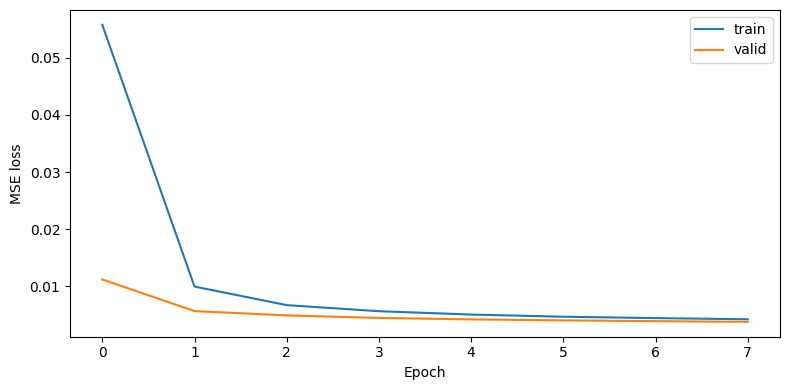

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(history['train'], label='train')
if not np.isnan(history['valid']).all():
    plt.plot(history['valid'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.legend()
plt.tight_layout()
plt.show()

### Create a prediction and compute score

Now that we have a model (albeit a crappy one) we can create a prediction. For this we need to create a forecast for each forecast initialization time in the testing range (2017-2018) and unnormalize it. We then convert the forecasts to a Xarray dataset which allows us to easily compute the RMSE. All of this is taken care of in the `create_predictions()` function.

In [ ]:
predictions = create_predictions(model, test_loader, test_ds, device)

In [ ]:
truth = rename_for_score(test_ds.ds[TARGET_VAR].sel(time=test_ds.valid_time))
preds_da = rename_for_score(predictions[TARGET_VAR])

rmse = compute_weighted_rmse(preds_da, truth, weights=None)
print(f"Weighted RMSE: {rmse.values.item():.4f}")


Weighted RMSE: 0.0354


### Compare predictions and truth

Visualize time-series at high-error locations (or user-selected coordinates) to inspect model performance.

- Set `comparison_coords` to a list of `(latitude, longitude)` pairs to examine specific sites.
- Adjust `time_window` (tuple of ISO timestamps) to focus on a particular period, or leave it as `None`.
- When `comparison_coords` is `None`, the top `num_points` locations by RMSE are displayed.


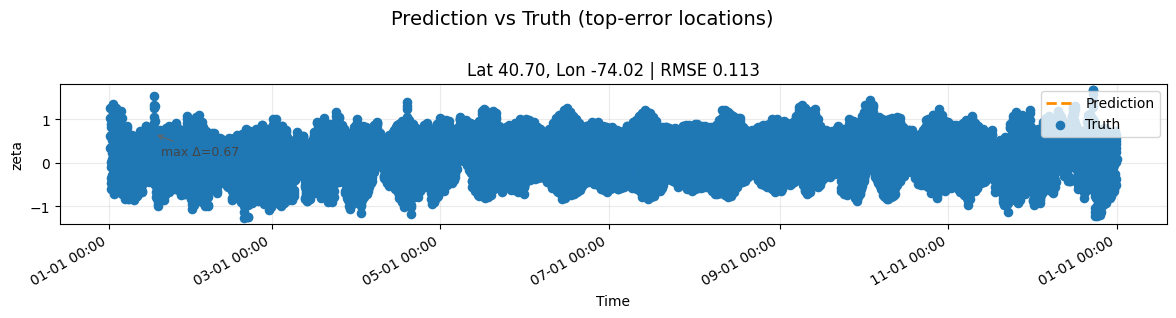

In [ ]:
# Configure which grid points to plot
# comparison_coords = None  # e.g., [(30.0, -90.0)]
comparison_coords = [(40.70, -74.015)]
num_points = 0  # used when comparison_coords is None
time_window = ("2022-01-01", "2022-12-31")  # e.g., ("2022-04-01", "2022-06-01")

# Determine shared time dimension names
pred_time_dim_candidates = [dim for dim in preds_da.dims if dim in ("time", "valid_time")]
pred_time_dim = pred_time_dim_candidates[0] if pred_time_dim_candidates else preds_da.dims[0]
truth_time_dim = pred_time_dim if pred_time_dim in truth.dims else ("time" if "time" in truth.dims else truth.dims[0])

# Optional temporal focus window
if time_window:
    start_time, end_time = time_window
    preds_window = preds_da.sel({pred_time_dim: slice(start_time, end_time)})
    truth_window = truth.sel({truth_time_dim: slice(start_time, end_time)})
else:
    preds_window = preds_da
    truth_window = truth

# Align on the shared coordinates/time axis and drop missing pairs
preds_window, truth_window = xr.align(preds_window, truth_window, join="inner")

rmse_time_dim_candidates = [dim for dim in preds_window.dims if dim in ("time", "valid_time")]
rmse_time_dim = rmse_time_dim_candidates[0] if rmse_time_dim_candidates else preds_window.dims[0]
rmse_map = np.sqrt(((preds_window - truth_window) ** 2).mean(dim=rmse_time_dim))
rmse_series = rmse_map.to_series().dropna()

# Decide which sites to visualize
selected_sites = []
if comparison_coords:
    for lat, lon in comparison_coords:
        truth_pt = truth_window.sel(latitude=lat, longitude=lon, method="nearest", drop=True)
        pred_pt = preds_window.sel(latitude=lat, longitude=lon, method="nearest", drop=True)
        rmse_val = float(np.sqrt(((pred_pt - truth_pt) ** 2).mean(dim=rmse_time_dim).values))
        actual_lat = float(truth_pt.latitude.values) if "latitude" in truth_pt.coords else float(lat)
        actual_lon = float(truth_pt.longitude.values) if "longitude" in truth_pt.coords else float(lon)
        selected_sites.append(((actual_lat, actual_lon), rmse_val))
else:
    top_series = rmse_series.nlargest(num_points)
    selected_sites = list(top_series.items())

if not selected_sites:
    raise ValueError("No comparison locations selected. Check inputs.")

fig, axes = plt.subplots(len(selected_sites), 1, figsize=(12, 3.2 * len(selected_sites)), sharex=True)
if len(selected_sites) == 1:
    axes = [axes]

for ax, (coord, rmse_val) in zip(axes, selected_sites):
    lat, lon = coord
    truth_pt = truth_window.sel(latitude=lat, longitude=lon, method="nearest", drop=True)
    pred_pt = preds_window.sel(latitude=lat, longitude=lon, method="nearest", drop=True)

    combined = xr.Dataset({
        "Truth": truth_pt,
        "Prediction": pred_pt,
    })
    df = combined.to_dataframe().reset_index()
    for col in ("latitude", "longitude", "lead_time"):
        if col in df:
            df = df.drop(columns=col)
    df = df.rename(columns={pred_time_dim: "time"})
    df = df.dropna(subset=["Truth", "Prediction"]).sort_values("time")

    if df.empty:
        ax.text(0.5, 0.5, "No overlapping timestamps", transform=ax.transAxes, ha="center", va="center")
        continue

    error = (df["Prediction"] - df["Truth"]).abs()
    ax.plot(df["time"], df["Prediction"], label="Prediction", color="#FF8C00", linewidth=2, linestyle="--")
    ax.scatter(df["time"], df["Truth"], label="Truth", color="#1f77b4", s=35, zorder=3)
    ax.plot(df["time"], df["Truth"], color="#1f77b4", linewidth=1, alpha=0.6)
    ax.fill_between(df["time"], df["Truth"], df["Prediction"], color="#1f77b4", alpha=0.12)

    max_idx = error.idxmax()
    if not error.empty:
        ax.annotate(
            f"max Δ={error.loc[max_idx]:.2f}",
            xy=(df.loc[max_idx, "time"], df.loc[max_idx, "Prediction"]),
            xytext=(5, -15),
            textcoords="offset points",
            fontsize=9,
            color="#444444",
            arrowprops=dict(arrowstyle="->", color="#666666", lw=0.8),
        )

    ax.set_title(f"Lat {lat:.2f}, Lon {lon:.2f} | RMSE {rmse_val:.3f}")
    ax.set_ylabel(TARGET_VAR)
    ax.grid(True, which="major", alpha=0.25)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))

axes[0].legend(loc="upper right")
axes[-1].set_xlabel("Time")
fig.autofmt_xdate()
fig.suptitle("Prediction vs Truth (top-error locations)", y=0.98, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


#### Interactive time-series comparison
Select a location from the dropdown to inspect the truth vs. prediction curves.
If `comparison_coords` is provided it drives the list; otherwise the top-RMSE sites are shown.


In [ ]:
from ipywidgets import interact, widgets
import plotly.graph_objects as go

# Prefer manually supplied coordinates; otherwise reuse the automatically selected ones
if comparison_coords:
    interactive_locations = list(comparison_coords)
else:
    interactive_locations = [coords for coords, _ in selected_sites]

if not interactive_locations:
    raise ValueError("No locations available for the interactive comparison widget.")

def _prepare_timeseries(lat, lon):
    truth_pt = truth_window.sel(latitude=lat, longitude=lon, method='nearest', drop=True)
    pred_pt = preds_window.sel(latitude=lat, longitude=lon, method='nearest', drop=True)
    combined = xr.Dataset({'Truth': truth_pt, 'Prediction': pred_pt})
    df = combined.to_dataframe().reset_index().dropna()
    df = df.rename(columns={pred_time_dim: 'time'})
    return df

def _label(lat, lon):
    return f"Lat {lat:.2f}°, Lon {lon:.2f}°"

options = [( _label(lat, lon), idx) for idx, (lat, lon) in enumerate(interactive_locations)]

@interact(location=widgets.Dropdown(options=options, description='Location'))
def show_interactive(location=0):
    lat, lon = interactive_locations[location]
    df = _prepare_timeseries(lat, lon)
    if df.empty:
        fig = go.Figure()
        fig.update_layout(title=f"{_label(lat, lon)} — no overlapping timestamps", xaxis_title='Time', yaxis_title=TARGET_VAR)
        return fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['time'], y=df['Truth'], mode='lines+markers', name='Truth'))
    fig.add_trace(go.Scatter(x=df['time'], y=df['Prediction'], mode='lines+markers', name='Prediction'))
    fig.update_layout(
        title=f'Interactive Comparison | {_label(lat, lon)}',
        xaxis_title='Time',
        yaxis_title=TARGET_VAR,
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
    )
    fig.show()


interactive(children=(Dropdown(description='Location', options=(('Lat 40.70°, Lon -74.02°', 0),), value=0), Ou…

# The End

This is the end of the quickstart guide. Please refer to the Jupyter notebooks in the `notebooks` directory for more examples. If you have questions, feel free to ask them as a Github Issue.